In [ ]:
!pip install kaggle

NameError: name 'kaggle' is not defined

In [ ]:
import kaggle


OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download bhaveshmittal/melanoma-cancer-dataset

 81% 64.0M/79.4M [00:00<00:00, 174MB/s]
100% 79.4M/79.4M [00:00<00:00, 157MB/s]


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!unzip melanoma-cancer-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import keras


In [ ]:
train_path = "/content/train"

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "training",
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size
)


Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Found 11879 files belonging to 2 classes.
Using 2375 files for validation.


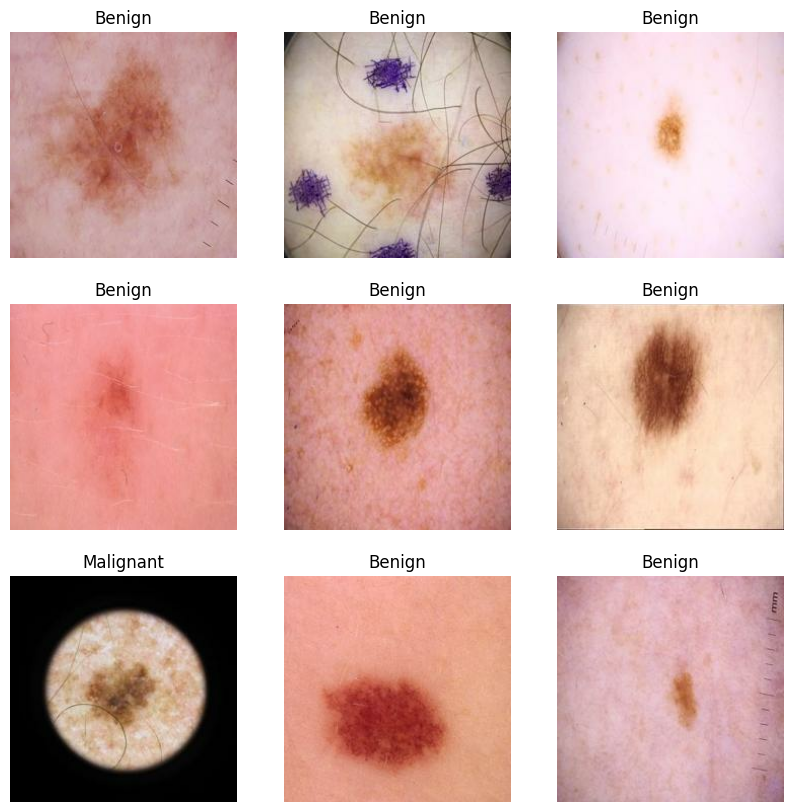

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:

augmentation_layers = [
    keras.layers.RandomRotation(factor=0.30),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomFlip(),
    keras.layers.RandomContrast(factor=0.1),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(factor=(-0.1, 0.1))
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x






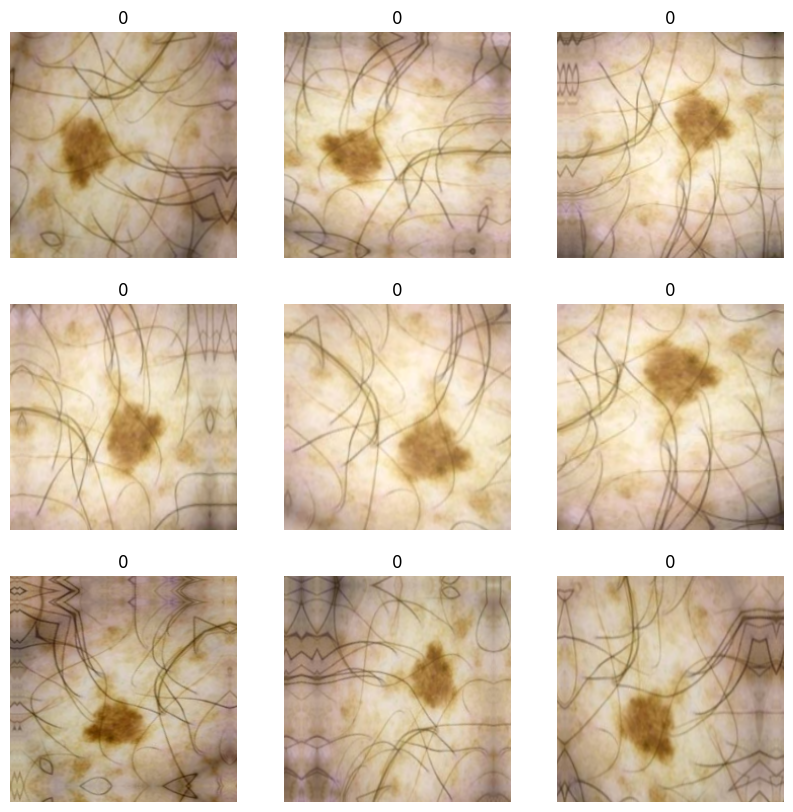

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
def input_preprocess_train(image, label):

    label = tf.one_hot(label, 2)
    return image, label
def input_preprocess_test(image, label):
    label = tf.one_hot(label, 2)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
def build_model(num_classes):
    inputs = keras.layers.Input(shape=(224, 224, 3))
    model = keras.applications.EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()],
    )
    return model


In [ ]:
model = build_model(num_classes=2)

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
epochs = 2
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/2
149/149 [==============================] - 165s 1s/step - loss: 0.4795 - binary_accuracy: 0.8202 - val_loss: 0.3564 - val_binary_accuracy: 0.8455
Epoch 2/2
149/149 [==============================] - 153s 1s/step - loss: 0.4189 - binary_accuracy: 0.8384 - val_loss: 0.3148 - val_binary_accuracy: 0.8745


In [ ]:
model.load_weights("EfficientNetV2B0.weights.h5")
total_layers = len(model.layers)


# Determine the index of the first layer to unfreeze
#first_layer_to_unfreeze = total_layers // 3 * 2  # Unfreeze from the last third of the layers


# Unfreeze the layers
#for layer in model.layers[first_layer_to_unfreeze:]:
#    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)


epochs = 1
model.fit(train_ds, epochs=epochs, validation_data=val_ds)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


149/149 [==============================] - 174s 1s/step - loss: 0.4310 - binary_accuracy: 0.8442 - val_loss: 0.3478 - val_binary_accuracy: 0.8766


In [ ]:
predictions = model.predict(val_ds)

38/38 [==============================] - 5s 91ms/step


In [ ]:
predictions

array([[9.9999893e-01, 1.1249648e-06],
       [2.0729503e-02, 9.7927046e-01],
       [9.9999285e-01, 7.1554673e-06],
       ...,
       [9.8012264e-05, 9.9990201e-01],
       [9.9999988e-01, 1.6202158e-07],
       [9.7662020e-01, 2.3379767e-02]], dtype=float32)

In [ ]:
x = np.array([])
for i in list(predictions):
  x = np.append(x, i[0])
x

array([9.99998927e-01, 2.07295027e-02, 9.99992847e-01, ...,
       9.80122641e-05, 9.99999881e-01, 9.76620197e-01])

In [ ]:
test_path = "/content/test"

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2000 files belonging to 2 classes.


In [ ]:
test_pred_manual = np.array([])
for image, label in test_ds:
    test_pred_manual = np.append(test_pred_manual, model.predict(image))

In [ ]:
test_labels = np.array([])
test_pred_manual = np.array([])
for image, label in test_ds:
    test_labels = np.append(test_labels, label)
    test_pred_manual = np.append(test_pred_manual, model.predict(image))



len(test_labels)

1/1 [==============================] - 3s 3s/step


2000

In [ ]:
x = np.array([])
for i, j in enumerate(test_pred_manual):
  if i%2 == 1:
    x = np.append(x,j)

In [ ]:
np.round(test_pred_manual)

array([0., 1., 1., ..., 1., 0., 1.])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
test_conf_mat = confusion_matrix(test_labels, np.round(x))

In [ ]:
print(test_conf_mat)

[[949  51]
 [240 760]]


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
x = np.array([])
for i, j in enumerate((test_pred_manual)):
  if i%2 == 1:
    x = np.append(x,j)

In [ ]:
fpr_xcep, tpr_xcep, thresh_xcep = roc_curve(test_labels, x)


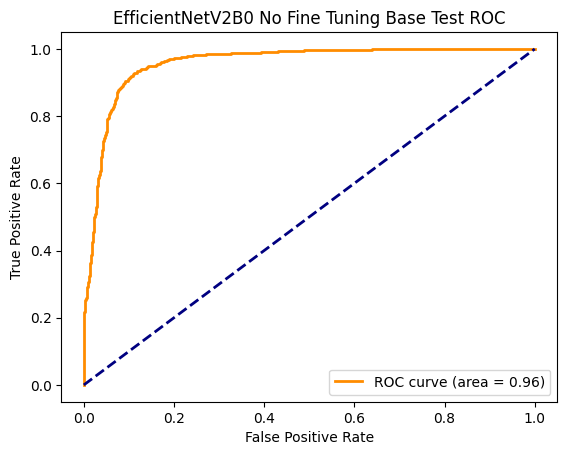

In [ ]:
roc_auc = auc(fpr_xcep, tpr_xcep)
plt.figure()
plt.plot(fpr_xcep, tpr_xcep, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetV2B0 No Fine Tuning Base Test ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
def calculate_recall_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    recall = recall_score(y_true, y_pred)
    return recall

def calculate_accuracy_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
recall_score(test_labels, np.round(x))

0.76

In [ ]:
calculate_accuracy_at_threshold(test_labels, x, 0.1)

0.9

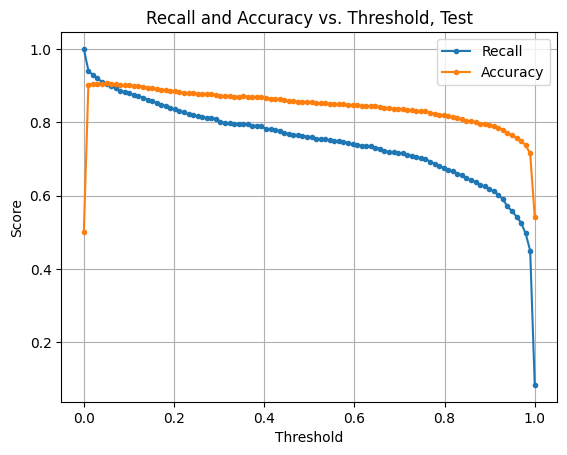

In [ ]:
thresholds = np.linspace(0, 1, 100)

# Calculate recall for each threshold
recalls = [calculate_recall_at_threshold(test_labels, x, threshold) for threshold in thresholds]
accuracies = [calculate_accuracy_at_threshold(test_labels, x, threshold) for threshold in thresholds]

# Plot recall and accuracy vs. threshold
# Plot recall vs. threshold
plt.plot(thresholds, recalls, marker='.', label='Recall')
plt.plot(thresholds, accuracies, marker='.', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')

plt.title('Recall and Accuracy vs. Threshold, Test')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
full_ds = keras.utils.image_dataset_from_directory(
    train_path,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 11879 files belonging to 2 classes.


In [ ]:
train_labs = np.array([])
train_preds = np.array([])
for image, label in full_ds:
  train_labs = np.append(train_labs, label)
  train_preds = np.append(train_preds, model.predict(image))

2/2 [==============================] - 0s 39ms/step


In [ ]:
y = np.array([])
for i, j in enumerate((train_preds)):
  if i%2 == 1:
    y = np.append(y,j)

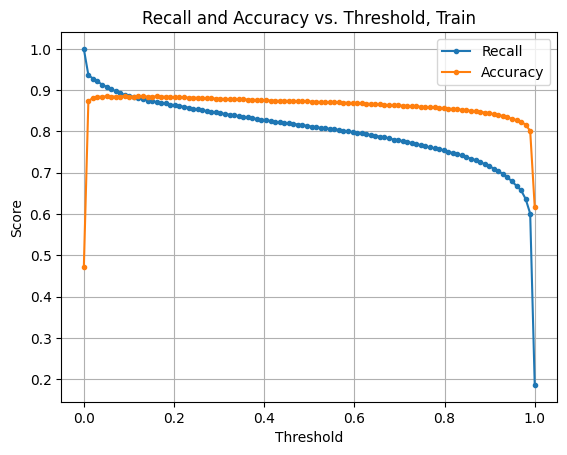

In [ ]:
recalls = [calculate_recall_at_threshold(train_labs, y, threshold) for threshold in thresholds]
accuracies = [calculate_accuracy_at_threshold(train_labs, y, threshold) for threshold in thresholds]

# Plot recall and accuracy vs. threshold
# Plot recall vs. threshold
plt.plot(thresholds, recalls, marker='.', label='Recall')
plt.plot(thresholds, accuracies, marker='.', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')

plt.title('Recall and Accuracy vs. Threshold, Train')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1

model.fit(train_ds, epochs=epochs, validation_data=val_ds)

NameError: name 'base_model' is not defined

In [ ]:
model.summary(show_trainable = True)

In [ ]:

keras.plot_hist(hist)

Epoch 1/2
149/149 [==============================] - 905s 6s/step - loss: 0.4862 - binary_accuracy: 0.8184 - val_loss: 0.3287 - val_binary_accuracy: 0.8695
Epoch 2/2
149/149 [==============================] - 940s 6s/step - loss: 0.4535 - binary_accuracy: 0.8294 - val_loss: 0.3240 - val_binary_accuracy: 0.8691


AttributeError: module 'keras' has no attribute 'plot_hist'

In [ ]:
model.save_weights("EfficientNetV2B0.weights.h5")

In [ ]:

total_layers = len(model.layers)

# Determine the index of the first layer to unfreeze
first_layer_to_unfreeze = total_layers // 3 * 2  # Unfreeze from the last third of the layers

# Unfreeze the layers
for layer in model.layers[first_layer_to_unfreeze:]:
    layer.trainable = True

In [ ]:
model.summary(show_trainable = True)